<a href="https://colab.research.google.com/github/RitaROK/Analysis/blob/main/Estimation_of_z.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install uncertainties

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.
import uncertainties.unumpy as unp 
import scipy
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, r_regression, SelectPercentile, mutual_info_regression, SequentialFeatureSelector
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import max_error, r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.model_selection import RepeatedKFold

def get_color(n, basecolor):
  current_palette = sns.dark_palette(n_colors=n, color=basecolor)
  sns.palplot(current_palette)
  colors = np.zeros(n, dtype=object)
  for color in range(n):
    colors[color] = current_palette[color]
  return colors

In [ ]:
#@title Load RoI data
roi = pd.read_csv('/content/drive/MyDrive/LIME/roi.csv')
roi['eta'] = roi['TSigma']*155 / roi['TAmp']

In [ ]:
#@title One Feature Fit Function

def onefeat(roi, feature, xmin, xmax):

  fig, (ax) = plt.subplots(1,2, figsize=(16, 9), dpi= 80, facecolor='w', edgecolor='k', gridspec_kw={'width_ratios': [2, 1]}) 

  # Background
  box = ax[0].boxplot(roi[feature].loc[roi['z[cm]']==0], positions=[0], widths=1, vert=0)
  plt.setp(box['whiskers'], color='k')
  plt.setp(box['fliers'], markeredgecolor='k')
  plt.setp(box['boxes'], color='k')
  plt.setp(box['caps'], color='k')
  plt.setp(box['medians'], color='k')

  violin = ax[0].violinplot(roi[feature].loc[roi['z[cm]']==0], positions=[0], widths=3, showextrema=False, vert=0)
  plt.setp(violin['bodies'], color='darkgray', alpha=1)

  # Source Data
  data = []
  for d in [5,10,15,20,25,30,35,40,45]:
      data.append(np.array(roi[feature].loc[roi['z[cm]']==d]))

  box = ax[0].boxplot(data, positions=[5,10,15,20,25,30,35,40,45], widths=1, vert=0)
  plt.setp(box['whiskers'], color='k')
  plt.setp(box['fliers'], markeredgecolor='k')
  plt.setp(box['boxes'], color='k')
  plt.setp(box['caps'], color='k')
  plt.setp(box['medians'], color='k')
  violin = ax[0].violinplot(data, positions=[5,10,15,20,25,30,35,40,45], widths=3, showextrema=False, vert=0)
  plt.setp(violin['bodies'], color='tab:orange', alpha=1)

  # Plot Settings
  ax[0].set_ylim(-2.5,50)

  ax[0].set_xlim(xmin, xmax)
  ax[0].spines["right"].set_visible(False)
  ax[0].spines["top"].set_visible(False)
  ax[0].set_xlabel(feature, y=0.5, ha='center', fontsize=22)
  ax[0].tick_params(axis='both', which='both', labelsize=22)
  ax[0].set_ylabel('Interaction Depth, $z$ [cm]', x=0.5, ha='center', fontsize=22)

  # Linear fit (1st order)
  Y = roi['z[cm]'].loc[roi['z[cm]']>=4]
  X = roi[[feature]].loc[roi['z[cm]']>=4]

  r2 = []
  RMSE = []
  MAE = []
  m = []
  b = []


  rkf = RepeatedKFold(n_splits=10, n_repeats=50, random_state=0)
  for train_index, test_index in rkf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    clf = LinearRegression().fit(X_train, y_train)
    preds = clf.predict(X_test)

    m.append(clf.coef_)
    b.append(clf.intercept_)
    r2.append(r2_score(y_test, preds))
    RMSE.append(np.sqrt(mean_squared_error(y_test, preds)))
    MAE.append(mean_absolute_error(y_test, preds))

  print('MODEL SUMMARY:')
  print('Cofficient: ', ufloat(np.mean(m), 3*np.std(m)))
  print('Intercept: ', ufloat(np.mean(b), 3*np.std(b)))
  print('r2 = ', ufloat(np.mean(r2), 3*np.std(r2)))
  print('RMSE = ', ufloat(np.mean(RMSE), 3*np.std(RMSE)))
  print('MAE = ', ufloat(np.mean(MAE), 3*np.std(MAE)))

  #predictions = model.get_prediction(xnew)
  #frame = predictions.summary_frame(alpha=0.05)
  #ax[0].fill_between(x, frame.obs_ci_lower, frame.obs_ci_upper, alpha=0.2, color='tab:blue', zorder=1)

  ax[0].plot(np.arange(xmin,xmax, 0.1), clf.predict(np.arange(xmin,xmax, 0.1).reshape(-1,1)), color='tab:blue')

  residuals = y_test-preds
  ax[1].hist(residuals, bins=50, color='tab:orange')
  ax[1].axvline(x=0, color='k', ls='--', lw=1.5)
  ax[1].spines["right"].set_visible(False)
  ax[1].spines["top"].set_visible(False)
  ax[1].set_xlabel('Residuals [cm]', y=0.5, ha='center', fontsize=22)
  ax[1].tick_params(axis='both', which='both', labelsize=22)
  ax[1].set_ylabel('Counts [-]', x=0.5, ha='center', fontsize=22)

  plt.show()

# Transverse Profile, $\eta$

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
Cofficient:  25.57+/-0.21
Intercept:  6.92+/-0.14
r2 =  0.170+/-0.016
RMSE =  11.25+/-0.14
MAE =  9.36+/-0.11


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


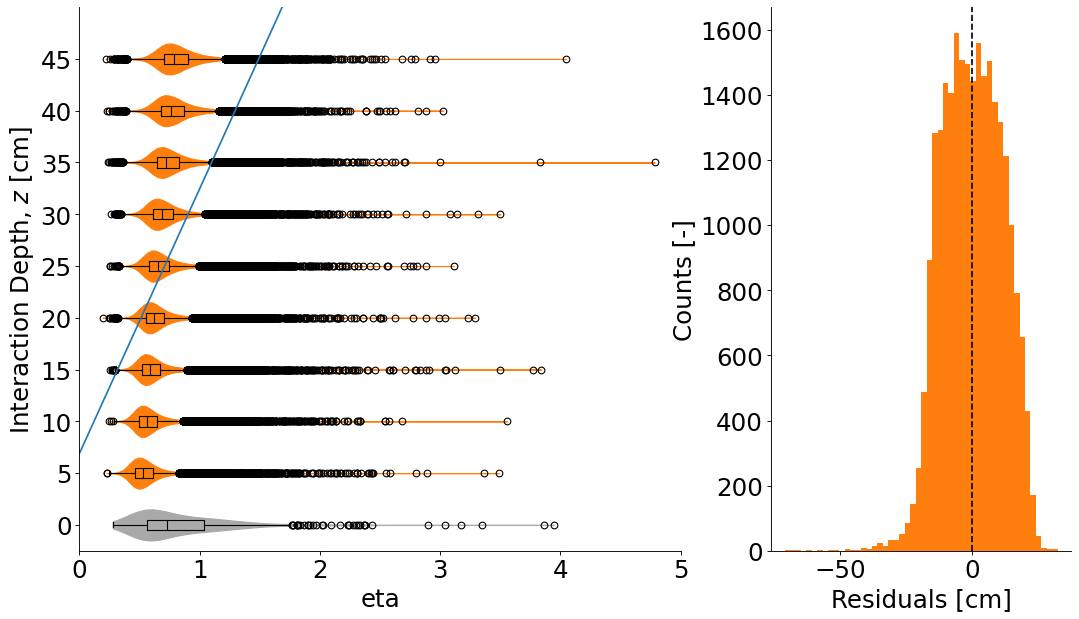

In [ ]:
feature = 'eta' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin =  0#@param {type:"number"}
xmax = 5 #@param {type:"number"}


onefeat(roi, feature, xmin, xmax)

# Original Features

In [ ]:
Y = roi['z[cm]'].loc[roi['z[cm]']>=4]
X = roi.drop(['z[cm]', 'Id'], axis=1).loc[roi['z[cm]']>=4]

## Filter Methods

## Basic Methods

In [ ]:
#@title Removal of constant and quasi-constant features
#@markdown The cluster Slimness, Pathlength, TStatus, LStatus, Person coefficient and Energy do not provide any information to the dataset.

#@markdown They will be removed from further analysis.
constant = []
print('Constant Features and how many times they were selected:')
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)
for train_index, test_index in rkf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
  sel = VarianceThreshold( threshold=0.01)
  sel.fit(X_train) 
  for feature in [x for x in X_train.columns if x not in X_train.columns[sel.get_support()]]:
    constant.append(feature)
for feature in set(constant):
  print(feature, constant.count(feature))
X=X.drop(set(constant), axis=1)
print('Selected columns:', X.columns)

Constant Features and how many times they were selected:
Pearson 100
Energy 100
TStatus 100
PathLen 100
Slim 100
LStatus 100
Selected columns: Index(['Hits', 'Integral', 'Length', 'Width', 'CorrIntegral', 'xMax', 'xMin',
       'yMax', 'yMin', 'yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta',
       'TMean', 'TAmp', 'TRMS', 'Size', 'RMS', 'Short_RMS', 'LChi2', 'LRMS',
       'LAmp', 'LMean', 'LSigma', 'Long_RMS', 'MAmp', 'MFWHM', 'MMean',
       'MProm', 'Pixel', 'eta'],
      dtype='object')


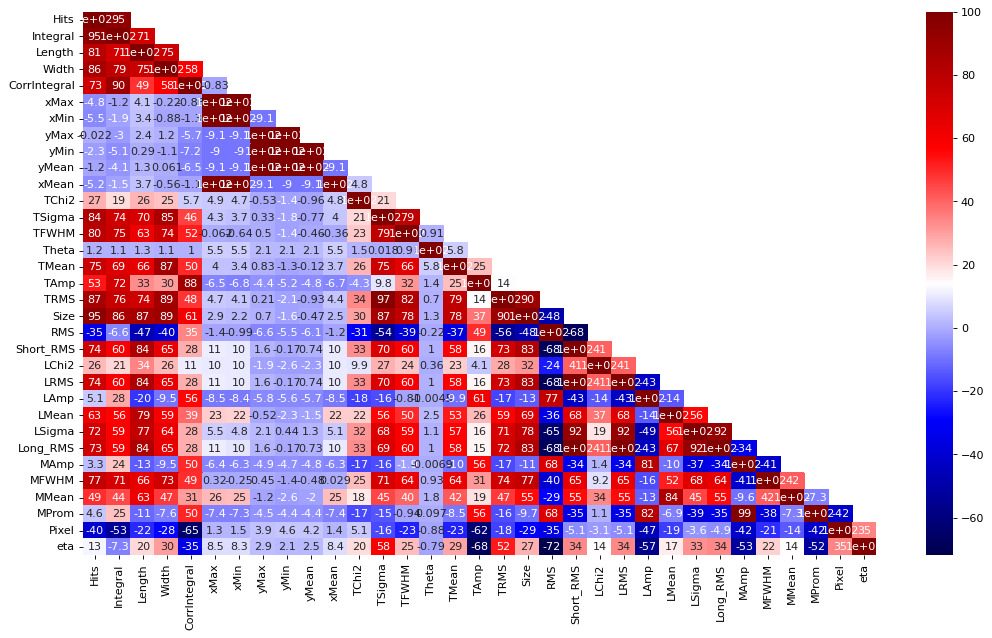

Hits and ['Integral' 'Width' 'TRMS' 'Size']
Integral and ['Hits' 'CorrIntegral' 'Size']
Length and ['Size']
Width and ['Hits' 'TMean' 'TRMS' 'Size']
CorrIntegral and ['Integral' 'TAmp']
xMax and ['xMin' 'xMean']
xMin and ['xMax' 'xMean']
yMax and ['yMin' 'yMean']
yMin and ['yMax' 'yMean']
yMean and ['yMax' 'yMin']
xMean and ['xMax' 'xMin']
TSigma and ['TRMS' 'Size']
TMean and ['Width']
TAmp and ['CorrIntegral']
TRMS and ['Hits' 'Width' 'TSigma' 'Size']
Size and ['Hits' 'Integral' 'Length' 'Width' 'TSigma' 'TRMS']
Short_RMS and ['LRMS' 'LSigma' 'Long_RMS']
LRMS and ['Short_RMS' 'LSigma' 'Long_RMS']
LSigma and ['Short_RMS' 'LRMS' 'Long_RMS']
Long_RMS and ['Short_RMS' 'LRMS' 'LSigma']
MAmp and ['MProm']
MProm and ['MAmp']


'----------------------------------------------------------------------------------------------------'

Features Correlation to the outcome:
z[cm]        1.000000
Hits         0.721759
Length       0.637626
Width        0.656132
TSigma       0.743639
TFWHM        0.650556
TRMS         0.763495
Size         0.736296
Short_RMS    0.708162
LRMS         0.708162
LSigma       0.707214
Long_RMS     0.706115
MFWHM        0.657159
Name: z[cm], dtype: float64
Remaining columns Index(['CorrIntegral', 'yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta',
       'RMS', 'LChi2', 'LAmp', 'LMean', 'LSigma', 'MAmp', 'MFWHM', 'MMean',
       'Pixel', 'eta'],
      dtype='object')


In [ ]:
#@title Correlation Coefficients
corr = X.corr()
upper = corr.where(np.tril(np.ones(corr.shape), k=1).astype(bool))
fig, (ax) = plt.subplots(figsize=(16, 9), dpi= 80, facecolor='w', edgecolor='k') 
sns.heatmap(upper*100, annot=True, cmap='seismic')
plt.show()

to_drop = [column for column in corr.columns if any(np.abs(corr[column]) >= 0.9)]
for feature in to_drop:
  corr_feat = np.asarray(corr.loc[(corr[feature] >= 0.85)].index)
  if len(corr_feat) > 1:
    print(feature, 'and', corr_feat[corr_feat!=feature])

display('-'*100)
print('Features Correlation to the outcome:')
z_corr = roi.drop(['TStatus', 'Pearson', 'LStatus', 'PathLen', 'Slim', 'Energy'], axis=1).corr()[['z[cm]']]
print(z_corr['z[cm]'].loc[np.abs(z_corr['z[cm]'])>=0.6])

X=X.drop(['xMax', 'xMin', 'yMax', 'yMin', 'MProm', 'Short_RMS', 'Long_RMS', 'LRMS', 'Integral', 'Hits', 'Size', 'TRMS', 'TAmp', 'Length', 'Width', 'TMean'], axis=1)
print('Remaining columns', X.columns)

## Statistical tests

In [ ]:
#@title Select 5 Best using F_regression
#@markdown I selected 5 features
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)

selected = np.asarray([])
scores = np.asarray([])
p = np.asarray([])
for train_index, test_index in rkf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
  sel = SelectKBest(f_regression, k=5)
  sel.fit(X_train, y_train)
  selected = np.append(selected, sel.get_feature_names_out())
  scores = np.append(scores, sel.scores_[sel.get_support(indices=True)])
  p = np.append(p, sel.pvalues_[sel.get_support(indices=True)])
data = {'Feature': selected,
        'F-Score': scores,
        'P-value': p}
df = pd.DataFrame(data)

for feature in df['Feature'].unique():
  print(feature, '\n \t f-score :', ufloat(df['F-Score'].loc[df['Feature']==feature].mean(), df['F-Score'].loc[df['Feature']==feature].std()), 
          '\n \t # selected :', df['F-Score'].loc[df['Feature']==feature].count(),
          '\n \t p-value :', ufloat(df['P-value'].loc[df['Feature']==feature].mean(), df['P-value'].loc[df['Feature']==feature].std()))
  display('-'*100)

TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TFWHM 
 	 f-score : (1.686+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

RMS 
 	 f-score : (1.1770+/-0.0032)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 f-score : (2.354+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

MFWHM 
 	 f-score : (1.751+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title Select 5 Best using r_regression
#@markdown I selected 5 features
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)

selected = np.asarray([])
scores = np.asarray([])
for train_index, test_index in rkf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
  sel = SelectKBest(r_regression, k=5)
  sel.fit(X_train, y_train)
  selected = np.append(selected, sel.get_feature_names_out())
  scores = np.append(scores, sel.scores_[sel.get_support(indices=True)])
data = {'Feature': selected,
        'R-Score': scores}
df = pd.DataFrame(data)

for feature in df['Feature'].unique():
  print(feature, '\n \t r-score :', ufloat(df['R-Score'].loc[df['Feature']==feature].mean(), df['R-Score'].loc[df['Feature']==feature].std()), 
          '\n \t # selected :', df['R-Score'].loc[df['Feature']==feature].count())
  display('-'*100)

TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TFWHM 
 	 r-score : 0.6540+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LMean 
 	 r-score : 0.4992+/-0.0005 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 r-score : 0.7146+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

MFWHM 
 	 r-score : 0.6610+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title Select 5 Best using mutual_info_regression
#@markdown I selected 5 features

rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)

selected = np.asarray([])
scores = np.asarray([])
for train_index, test_index in rkf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
  sel = SelectKBest(mutual_info_regression, k=5)
  sel.fit(X_train, y_train)
  selected = np.append(selected, sel.get_feature_names_out())
  scores = np.append(scores, sel.scores_[sel.get_support(indices=True)])
data = {'Feature': selected,
        'Info-Score': scores}
df = pd.DataFrame(data)

for feature in df['Feature'].unique():
  print(feature, '\n \t score :', ufloat(df['Info-Score'].loc[df['Feature']==feature].mean(), df['Info-Score'].loc[df['Feature']==feature].std()), 
          '\n \t # selected :', df['Info-Score'].loc[df['Feature']==feature].count())
  display('-'*100)

TSigma 
 	 score : 0.4870+/-0.0009 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TFWHM 
 	 score : 0.3495+/-0.0008 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

RMS 
 	 score : 0.2551+/-0.0009 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 score : 0.3882+/-0.0009 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

MFWHM 
 	 score : 0.3093+/-0.0007 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

## One Feature Models

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
Cofficient:  10.362+/-0.022
Intercept:  -26.89+/-0.11
r2 =  0.560+/-0.015
RMSE =  8.19+/-0.14
MAE =  6.25+/-0.09


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


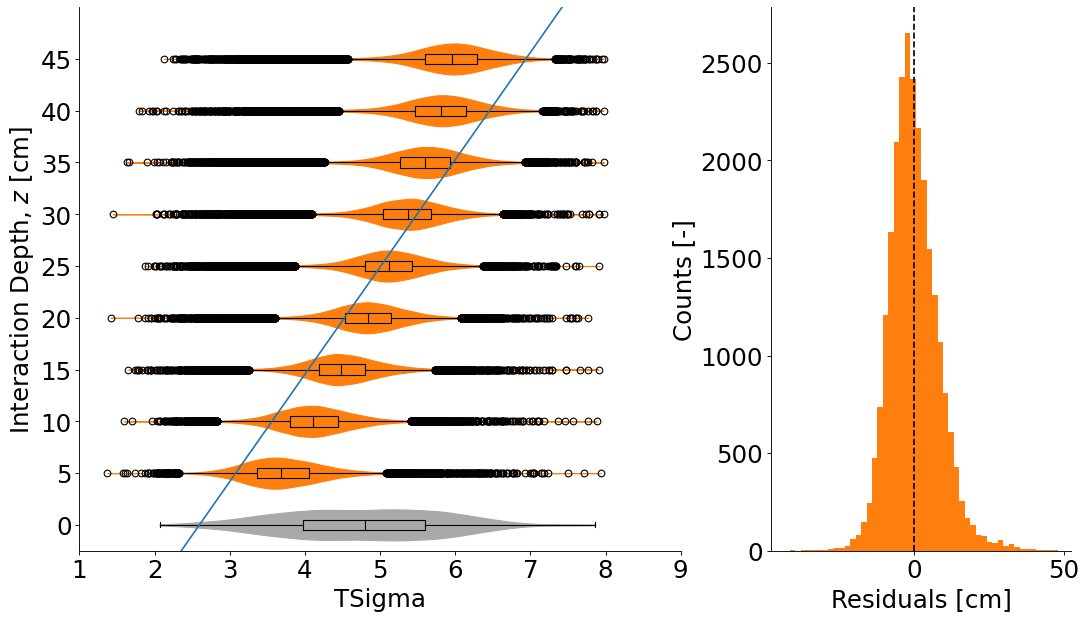

In [ ]:
feature = 'TSigma' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin =  1#@param {type:"number"}
xmax =  9#@param {type:"number"}


onefeat(roi, feature, xmin, xmax)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
Cofficient:  8.158+/-0.015
Intercept:  -25.86+/-0.09
r2 =  0.511+/-0.013
RMSE =  8.64+/-0.12
MAE =  6.80+/-0.09


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


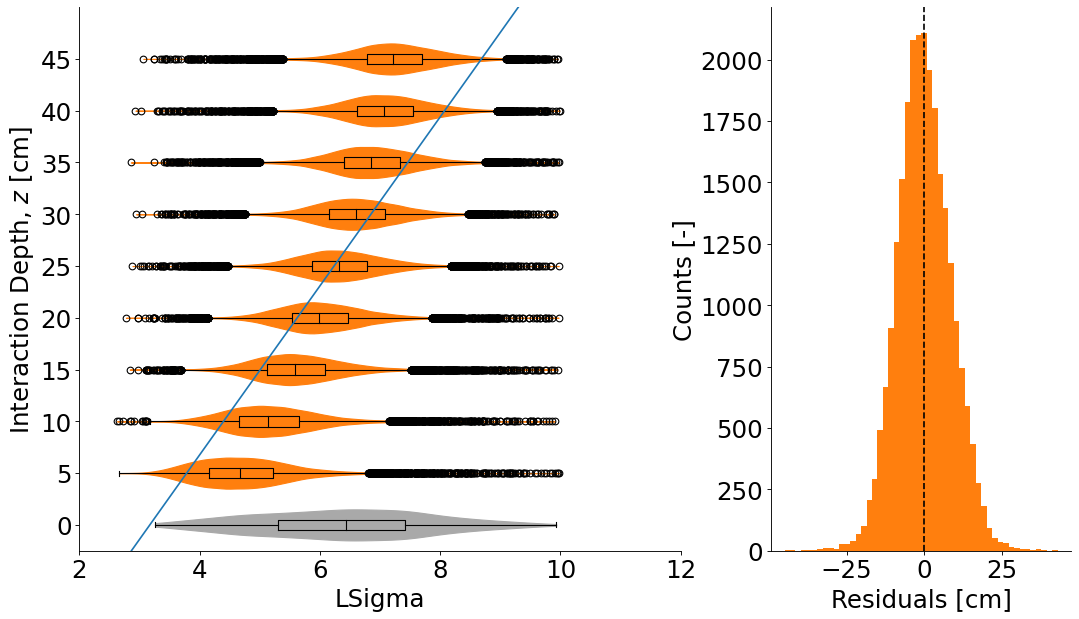

In [ ]:
feature = 'LSigma' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin =  2#@param {type:"number"}
xmax =  12#@param {type:"number"}


onefeat(roi, feature, xmin, xmax)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
Cofficient:  4.711+/-0.010
Intercept:  -1.79+/-0.06
r2 =  0.437+/-0.015
RMSE =  9.27+/-0.13
MAE =  7.43+/-0.10


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


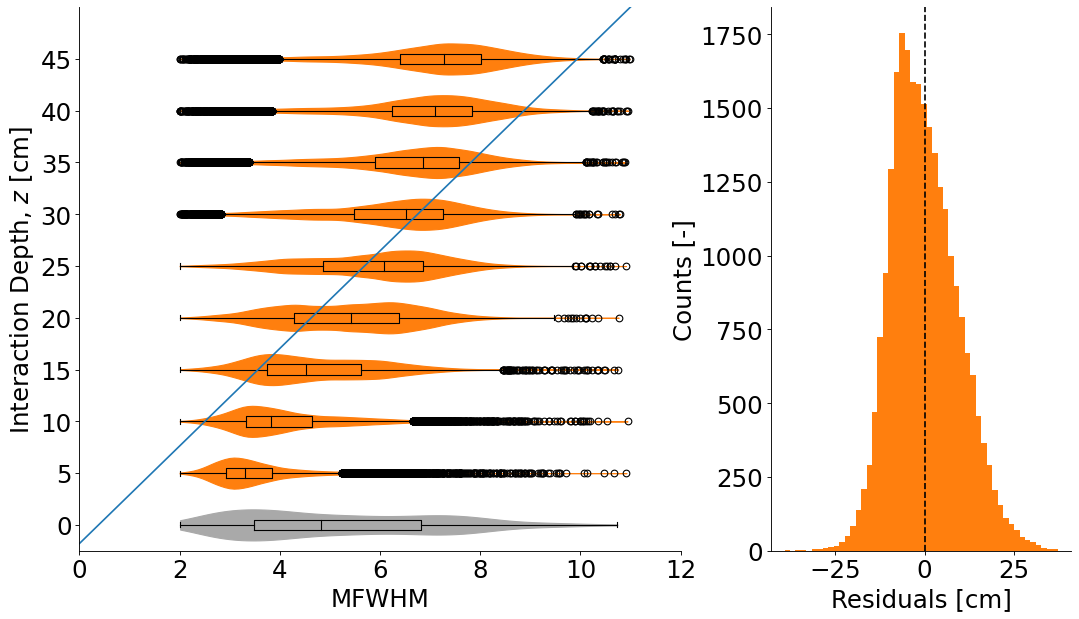

In [ ]:
feature = 'MFWHM' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin =  0#@param {type:"number"}
xmax =  12#@param {type:"number"}


onefeat(roi, feature, xmin, xmax)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
Cofficient:  6.541+/-0.017
Intercept:  -13.77+/-0.11
r2 =  0.428+/-0.016
RMSE =  9.34+/-0.14
MAE =  7.42+/-0.10


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


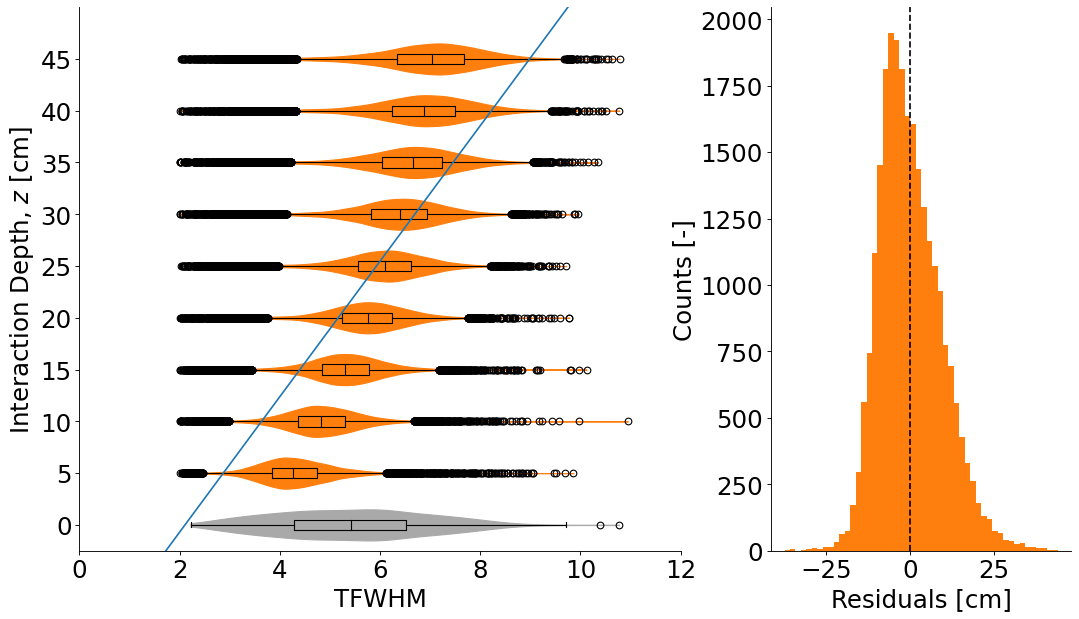

In [ ]:
feature = 'TFWHM' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin =  0#@param {type:"number"}
xmax =  12#@param {type:"number"}


onefeat(roi, feature, xmin, xmax)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
Cofficient:  -4.445+/-0.013
Intercept:  82.90+/-0.18
r2 =  0.343+/-0.015
RMSE =  10.01+/-0.13
MAE =  8.08+/-0.10


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


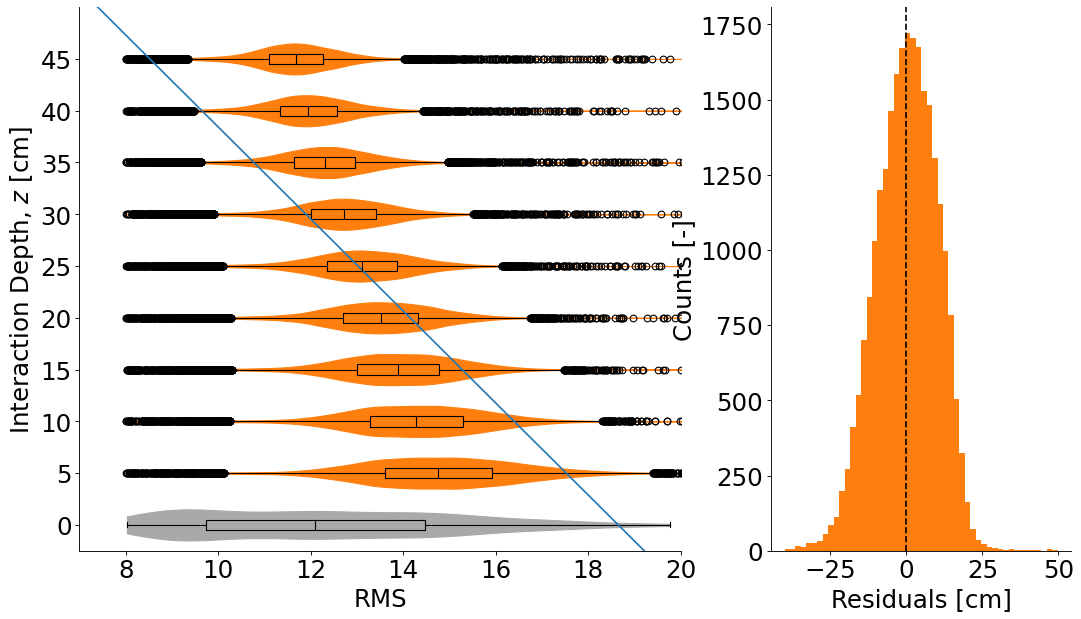

In [ ]:
feature = 'RMS' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin =  7#@param {type:"number"}
xmax =  20#@param {type:"number"}


onefeat(roi, feature, xmin, xmax)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
Cofficient:  2.010+/-0.007
Intercept:  -12.98+/-0.13
r2 =  0.249+/-0.014
RMSE =  10.70+/-0.11
MAE =  8.81+/-0.11


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


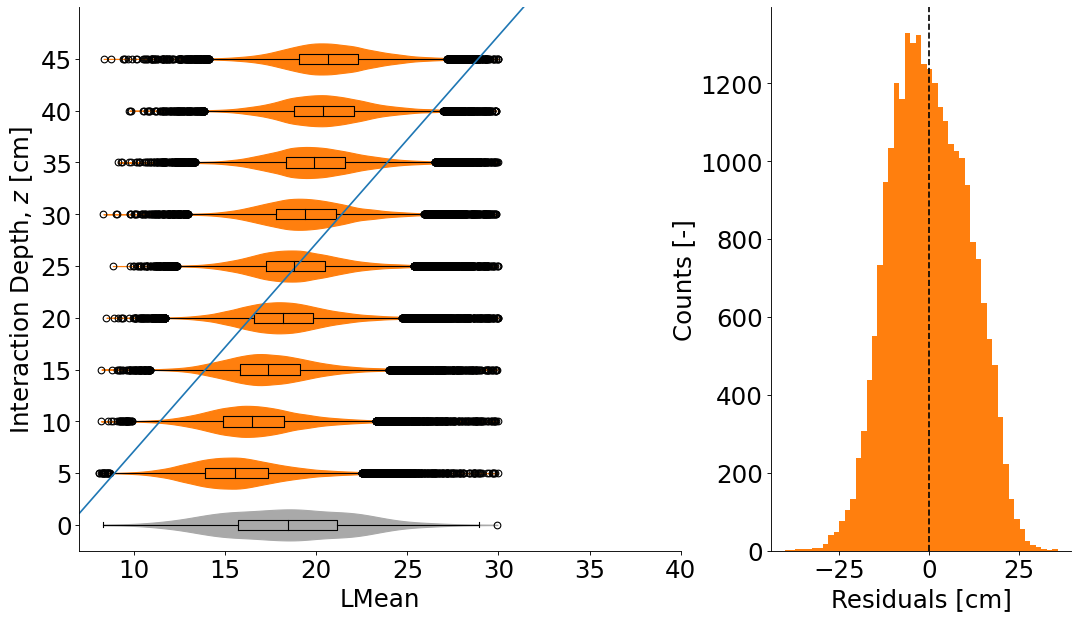

In [ ]:
feature = 'LMean' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin =  7#@param {type:"number"}
xmax =  35#@param {type:"number"}


onefeat(roi, feature, xmin, xmax)

# 2nd order Interactions

In [ ]:
#@title Initialization and interaction function
#Y = roi['z[cm]'].loc[roi['z[cm]']>=4]
#X = roi.drop(['z[cm]', 'Id'], axis=1).loc[roi['z[cm]']>=4]
#X = X.drop(['Pearson','Energy','TStatus','PathLen','Slim','LStatus','xMax', 'xMin', 'yMax', 'yMin', 'MProm', 'Short_RMS', 'Long_RMS', 'LRMS', 'Integral', 'Hits', 'Size', 'TRMS', 'TAmp', 'Length', 'Width', 'TMean'], axis=1)
#original_len = len(X.columns)

def interaction(feature):
  Y = roi['z[cm]'].loc[roi['z[cm]']>=4]
  X = roi.drop(['z[cm]', 'Id'], axis=1).loc[roi['z[cm]']>=4]
  X = X.drop(['Pearson','Energy','TStatus','PathLen','Slim','LStatus','xMax', 'xMin', 'yMax', 'yMin', 'MProm', 'Short_RMS', 'Long_RMS', 'LRMS', 'Integral', 'Hits', 'Size', 'TRMS', 'TAmp', 'Length', 'Width', 'TMean'], axis=1)
  original_len = len(X.columns)

  for feat in X.drop(feature, axis=1).columns[:original_len]:
    if (np.asarray(X[feat]).all() != 0):
      X[feature+'*'+feat] = X[feature]*X[feat]
      X[feature+'/'+feat] = X[feature]/X[feat]
    else:
      print(feat)
  print(X.columns)

  print('F-regression')
  rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)

  selected = np.asarray([])
  scores = np.asarray([])
  p = np.asarray([])
  for train_index, test_index in rkf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    sel = SelectKBest(f_regression, k=5)
    sel.fit(X_train, y_train)
    selected = np.append(selected, sel.get_feature_names_out())
    scores = np.append(scores, sel.scores_[sel.get_support(indices=True)])
    p = np.append(p, sel.pvalues_[sel.get_support(indices=True)])
  data = {'Feature': selected,
        'F-Score': scores,
        'P-value': p}
  df = pd.DataFrame(data)

  for feature in df['Feature'].unique():
    print(feature, '\n \t f-score :', ufloat(df['F-Score'].loc[df['Feature']==feature].mean(), df['F-Score'].loc[df['Feature']==feature].std()), 
          '\n \t # selected :', df['F-Score'].loc[df['Feature']==feature].count(),
          '\n \t p-value :', ufloat(df['P-value'].loc[df['Feature']==feature].mean(), df['P-value'].loc[df['Feature']==feature].std()))
    display('-'*100)

  print('R-regression')

  selected = np.asarray([])
  scores = np.asarray([])
  for train_index, test_index in rkf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    sel = SelectKBest(r_regression, k=5)
    sel.fit(X_train, y_train)
    selected = np.append(selected, sel.get_feature_names_out())
    scores = np.append(scores, sel.scores_[sel.get_support(indices=True)])
  data = {'Feature': selected,
        'R-Score': scores}
  df = pd.DataFrame(data)

  for feature in df['Feature'].unique():
    print(feature, '\n \t r-score :', ufloat(df['R-Score'].loc[df['Feature']==feature].mean(), df['R-Score'].loc[df['Feature']==feature].std()), 
          '\n \t # selected :', df['R-Score'].loc[df['Feature']==feature].count())
    display('-'*100)

  # Run only for sigma_T and sigma_L (takes a lot of time)
  print('Mutual Information')
  selected = np.asarray([])
  scores = np.asarray([])
  for train_index, test_index in rkf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    sel = SelectKBest(mutual_info_regression, k=5)
    sel.fit(X_train, y_train)
    selected = np.append(selected, sel.get_feature_names_out())
    scores = np.append(scores, sel.scores_[sel.get_support(indices=True)])
  data = {'Feature': selected,
        'Info-Score': scores}
  df = pd.DataFrame(data)

  for feature in df['Feature'].unique():
    print(feature, '\n \t score :', ufloat(df['Info-Score'].loc[df['Feature']==feature].mean(), df['Info-Score'].loc[df['Feature']==feature].std()), 
          '\n \t # selected :', df['Info-Score'].loc[df['Feature']==feature].count())
    display('-'*100)

In [ ]:
#@title $\sigma_T$
interaction('TSigma')

Theta
Pixel
Index(['CorrIntegral', 'yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta',
       'RMS', 'LChi2', 'LAmp', 'LMean', 'LSigma', 'MAmp', 'MFWHM', 'MMean',
       'Pixel', 'eta', 'TSigma*CorrIntegral', 'TSigma/CorrIntegral',
       'TSigma*yMean', 'TSigma/yMean', 'TSigma*xMean', 'TSigma/xMean',
       'TSigma*TChi2', 'TSigma/TChi2', 'TSigma*TFWHM', 'TSigma/TFWHM',
       'TSigma*RMS', 'TSigma/RMS', 'TSigma*LChi2', 'TSigma/LChi2',
       'TSigma*LAmp', 'TSigma/LAmp', 'TSigma*LMean', 'TSigma/LMean',
       'TSigma*LSigma', 'TSigma/LSigma', 'TSigma*MAmp', 'TSigma/MAmp',
       'TSigma*MFWHM', 'TSigma/MFWHM', 'TSigma*MMean', 'TSigma/MMean',
       'TSigma*eta', 'TSigma/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TSigma*TFWHM 
 	 f-score : (2.700+/-0.006)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TSigma/RMS 
 	 f-score : (3.114+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TSigma*LSigma 
 	 f-score : (3.983+/-0.009)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TSigma*MFWHM 
 	 f-score : (2.744+/-0.006)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TSigma*TFWHM 
 	 r-score : 0.7381+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TSigma/RMS 
 	 r-score : 0.7615+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TSigma*LSigma 
 	 r-score : 0.79900+/-0.00033 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TSigma*MFWHM 
 	 r-score : 0.7408+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

Mutual Information
TSigma 
 	 score : 0.4870+/-0.0009 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TSigma*TFWHM 
 	 score : 0.4708+/-0.0008 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TSigma/RMS 
 	 score : 0.4928+/-0.0009 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TSigma*LSigma 
 	 score : 0.5630+/-0.0008 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TSigma*MFWHM 
 	 score : 0.4378+/-0.0009 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title $\sigma_L$
interaction('LSigma')

Theta
Pixel
Index(['CorrIntegral', 'yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta',
       'RMS', 'LChi2', 'LAmp', 'LMean', 'LSigma', 'MAmp', 'MFWHM', 'MMean',
       'Pixel', 'eta', 'LSigma*CorrIntegral', 'LSigma/CorrIntegral',
       'LSigma*yMean', 'LSigma/yMean', 'LSigma*xMean', 'LSigma/xMean',
       'LSigma*TChi2', 'LSigma/TChi2', 'LSigma*TSigma', 'LSigma/TSigma',
       'LSigma*TFWHM', 'LSigma/TFWHM', 'LSigma*RMS', 'LSigma/RMS',
       'LSigma*LChi2', 'LSigma/LChi2', 'LSigma*LAmp', 'LSigma/LAmp',
       'LSigma*LMean', 'LSigma/LMean', 'LSigma*MAmp', 'LSigma/MAmp',
       'LSigma*MFWHM', 'LSigma/MFWHM', 'LSigma*MMean', 'LSigma/MMean',
       'LSigma*eta', 'LSigma/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 f-score : (2.354+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma*TSigma 
 	 f-score : (3.983+/-0.009)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma*TFWHM 
 	 f-score : (3.091+/-0.006)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma*MFWHM 
 	 f-score : (2.504+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 r-score : 0.7146+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma*TSigma 
 	 r-score : 0.79900+/-0.00033 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma*TFWHM 
 	 r-score : 0.76032+/-0.00033 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma*MFWHM 
 	 r-score : 0.7253+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

Mutual Information
TSigma 
 	 score : 0.4870+/-0.0009 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma*TSigma 
 	 score : 0.5630+/-0.0008 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma*TFWHM 
 	 score : 0.4882+/-0.0008 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma/RMS 
 	 score : 0.4056+/-0.0008 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma*MFWHM 
 	 score : 0.4050+/-0.0008 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title CorrIntegral
interaction('CorrIntegral')

Theta
Pixel
Index(['CorrIntegral', 'yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta',
       'RMS', 'LChi2', 'LAmp', 'LMean', 'LSigma', 'MAmp', 'MFWHM', 'MMean',
       'Pixel', 'eta', 'CorrIntegral*yMean', 'CorrIntegral/yMean',
       'CorrIntegral*xMean', 'CorrIntegral/xMean', 'CorrIntegral*TChi2',
       'CorrIntegral/TChi2', 'CorrIntegral*TSigma', 'CorrIntegral/TSigma',
       'CorrIntegral*TFWHM', 'CorrIntegral/TFWHM', 'CorrIntegral*RMS',
       'CorrIntegral/RMS', 'CorrIntegral*LChi2', 'CorrIntegral/LChi2',
       'CorrIntegral*LAmp', 'CorrIntegral/LAmp', 'CorrIntegral*LMean',
       'CorrIntegral/LMean', 'CorrIntegral*LSigma', 'CorrIntegral/LSigma',
       'CorrIntegral*MAmp', 'CorrIntegral/MAmp', 'CorrIntegral*MFWHM',
       'CorrIntegral/MFWHM', 'CorrIntegral*MMean', 'CorrIntegral/MMean',
       'CorrIntegral*eta', 'CorrIntegral/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TFWHM 
 	 f-score : (1.686+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 f-score : (2.354+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

MFWHM 
 	 f-score : (1.751+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

CorrIntegral*eta 
 	 f-score : (1.803+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TFWHM 
 	 r-score : 0.6540+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 r-score : 0.7146+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

MFWHM 
 	 r-score : 0.6610+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

CorrIntegral*eta 
 	 r-score : 0.6664+/-0.0005 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title $y$Mean
interaction('yMean')

Theta
Pixel
Index(['CorrIntegral', 'yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta',
       'RMS', 'LChi2', 'LAmp', 'LMean', 'LSigma', 'MAmp', 'MFWHM', 'MMean',
       'Pixel', 'eta', 'yMean*CorrIntegral', 'yMean/CorrIntegral',
       'yMean*xMean', 'yMean/xMean', 'yMean*TChi2', 'yMean/TChi2',
       'yMean*TSigma', 'yMean/TSigma', 'yMean*TFWHM', 'yMean/TFWHM',
       'yMean*RMS', 'yMean/RMS', 'yMean*LChi2', 'yMean/LChi2', 'yMean*LAmp',
       'yMean/LAmp', 'yMean*LMean', 'yMean/LMean', 'yMean*LSigma',
       'yMean/LSigma', 'yMean*MAmp', 'yMean/MAmp', 'yMean*MFWHM',
       'yMean/MFWHM', 'yMean*MMean', 'yMean/MMean', 'yMean*eta', 'yMean/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TFWHM 
 	 f-score : (1.686+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 f-score : (2.354+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

MFWHM 
 	 f-score : (1.751+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

yMean*MFWHM 
 	 f-score : (1.1852+/-0.0026)e+05 
 	 # selected : 96 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

RMS 
 	 f-score : (1.1824+/-0.0014)e+05 
 	 # selected : 4 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TFWHM 
 	 r-score : 0.6540+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 r-score : 0.7146+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

MFWHM 
 	 r-score : 0.6610+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

yMean*MFWHM 
 	 r-score : 0.5868+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title $x$Mean
interaction('xMean')

Theta
Pixel
Index(['CorrIntegral', 'yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta',
       'RMS', 'LChi2', 'LAmp', 'LMean', 'LSigma', 'MAmp', 'MFWHM', 'MMean',
       'Pixel', 'eta', 'xMean*CorrIntegral', 'xMean/CorrIntegral',
       'xMean*yMean', 'xMean/yMean', 'xMean*TChi2', 'xMean/TChi2',
       'xMean*TSigma', 'xMean/TSigma', 'xMean*TFWHM', 'xMean/TFWHM',
       'xMean*RMS', 'xMean/RMS', 'xMean*LChi2', 'xMean/LChi2', 'xMean*LAmp',
       'xMean/LAmp', 'xMean*LMean', 'xMean/LMean', 'xMean*LSigma',
       'xMean/LSigma', 'xMean*MAmp', 'xMean/MAmp', 'xMean*MFWHM',
       'xMean/MFWHM', 'xMean*MMean', 'xMean/MMean', 'xMean*eta', 'xMean/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TFWHM 
 	 f-score : (1.686+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

RMS 
 	 f-score : (1.1770+/-0.0032)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 f-score : (2.354+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

MFWHM 
 	 f-score : (1.751+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TFWHM 
 	 r-score : 0.6540+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LMean 
 	 r-score : 0.4992+/-0.0005 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 r-score : 0.7146+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

MFWHM 
 	 r-score : 0.6610+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title $\chi^2_T$
interaction('TChi2')

Theta
Pixel
Index(['CorrIntegral', 'yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta',
       'RMS', 'LChi2', 'LAmp', 'LMean', 'LSigma', 'MAmp', 'MFWHM', 'MMean',
       'Pixel', 'eta', 'TChi2*CorrIntegral', 'TChi2/CorrIntegral',
       'TChi2*yMean', 'TChi2/yMean', 'TChi2*xMean', 'TChi2/xMean',
       'TChi2*TSigma', 'TChi2/TSigma', 'TChi2*TFWHM', 'TChi2/TFWHM',
       'TChi2*RMS', 'TChi2/RMS', 'TChi2*LChi2', 'TChi2/LChi2', 'TChi2*LAmp',
       'TChi2/LAmp', 'TChi2*LMean', 'TChi2/LMean', 'TChi2*LSigma',
       'TChi2/LSigma', 'TChi2*MAmp', 'TChi2/MAmp', 'TChi2*MFWHM',
       'TChi2/MFWHM', 'TChi2*MMean', 'TChi2/MMean', 'TChi2*eta', 'TChi2/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TFWHM 
 	 f-score : (1.686+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

RMS 
 	 f-score : (1.1770+/-0.0032)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 f-score : (2.354+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

MFWHM 
 	 f-score : (1.751+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TFWHM 
 	 r-score : 0.6540+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 r-score : 0.7146+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

MFWHM 
 	 r-score : 0.6610+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TChi2*MFWHM 
 	 r-score : 0.5129+/-0.0005 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title FWHM$_T$
interaction('TFWHM')

Theta
Pixel
Index(['CorrIntegral', 'yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta',
       'RMS', 'LChi2', 'LAmp', 'LMean', 'LSigma', 'MAmp', 'MFWHM', 'MMean',
       'Pixel', 'eta', 'TFWHM*CorrIntegral', 'TFWHM/CorrIntegral',
       'TFWHM*yMean', 'TFWHM/yMean', 'TFWHM*xMean', 'TFWHM/xMean',
       'TFWHM*TChi2', 'TFWHM/TChi2', 'TFWHM*TSigma', 'TFWHM/TSigma',
       'TFWHM*RMS', 'TFWHM/RMS', 'TFWHM*LChi2', 'TFWHM/LChi2', 'TFWHM*LAmp',
       'TFWHM/LAmp', 'TFWHM*LMean', 'TFWHM/LMean', 'TFWHM*LSigma',
       'TFWHM/LSigma', 'TFWHM*MAmp', 'TFWHM/MAmp', 'TFWHM*MFWHM',
       'TFWHM/MFWHM', 'TFWHM*MMean', 'TFWHM/MMean', 'TFWHM*eta', 'TFWHM/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TFWHM*TSigma 
 	 f-score : (2.700+/-0.006)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TFWHM/RMS 
 	 f-score : (2.602+/-0.006)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TFWHM*LSigma 
 	 f-score : (3.091+/-0.006)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TFWHM*MFWHM 
 	 f-score : (2.375+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TFWHM*TSigma 
 	 r-score : 0.7381+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TFWHM/RMS 
 	 r-score : 0.7318+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TFWHM*LSigma 
 	 r-score : 0.76032+/-0.00033 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TFWHM*MFWHM 
 	 r-score : 0.7161+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title $\theta$
interaction('Theta')

Pixel
Index(['CorrIntegral', 'yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta',
       'RMS', 'LChi2', 'LAmp', 'LMean', 'LSigma', 'MAmp', 'MFWHM', 'MMean',
       'Pixel', 'eta', 'Theta*CorrIntegral', 'Theta/CorrIntegral',
       'Theta*yMean', 'Theta/yMean', 'Theta*xMean', 'Theta/xMean',
       'Theta*TChi2', 'Theta/TChi2', 'Theta*TSigma', 'Theta/TSigma',
       'Theta*TFWHM', 'Theta/TFWHM', 'Theta*RMS', 'Theta/RMS', 'Theta*LChi2',
       'Theta/LChi2', 'Theta*LAmp', 'Theta/LAmp', 'Theta*LMean', 'Theta/LMean',
       'Theta*LSigma', 'Theta/LSigma', 'Theta*MAmp', 'Theta/MAmp',
       'Theta*MFWHM', 'Theta/MFWHM', 'Theta*MMean', 'Theta/MMean', 'Theta*eta',
       'Theta/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TFWHM 
 	 f-score : (1.686+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

RMS 
 	 f-score : (1.1770+/-0.0032)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 f-score : (2.354+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

MFWHM 
 	 f-score : (1.751+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TFWHM 
 	 r-score : 0.6540+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LMean 
 	 r-score : 0.4992+/-0.0005 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 r-score : 0.7146+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

MFWHM 
 	 r-score : 0.6610+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title RMS
interaction('RMS')

Theta
Pixel
Index(['CorrIntegral', 'yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta',
       'RMS', 'LChi2', 'LAmp', 'LMean', 'LSigma', 'MAmp', 'MFWHM', 'MMean',
       'Pixel', 'eta', 'RMS*CorrIntegral', 'RMS/CorrIntegral', 'RMS*yMean',
       'RMS/yMean', 'RMS*xMean', 'RMS/xMean', 'RMS*TChi2', 'RMS/TChi2',
       'RMS*TSigma', 'RMS/TSigma', 'RMS*TFWHM', 'RMS/TFWHM', 'RMS*LChi2',
       'RMS/LChi2', 'RMS*LAmp', 'RMS/LAmp', 'RMS*LMean', 'RMS/LMean',
       'RMS*LSigma', 'RMS/LSigma', 'RMS*MAmp', 'RMS/MAmp', 'RMS*MFWHM',
       'RMS/MFWHM', 'RMS*MMean', 'RMS/MMean', 'RMS*eta', 'RMS/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 f-score : (2.354+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

RMS/TSigma 
 	 f-score : (2.666+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

RMS/TFWHM 
 	 f-score : (2.097+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

RMS/LSigma 
 	 f-score : (2.189+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TFWHM 
 	 r-score : 0.6540+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LMean 
 	 r-score : 0.4992+/-0.0005 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 r-score : 0.7146+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

MFWHM 
 	 r-score : 0.6610+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title $\chi^2_L$
interaction('LChi2')

Theta
Pixel
Index(['CorrIntegral', 'yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta',
       'RMS', 'LChi2', 'LAmp', 'LMean', 'LSigma', 'MAmp', 'MFWHM', 'MMean',
       'Pixel', 'eta', 'LChi2*CorrIntegral', 'LChi2/CorrIntegral',
       'LChi2*yMean', 'LChi2/yMean', 'LChi2*xMean', 'LChi2/xMean',
       'LChi2*TChi2', 'LChi2/TChi2', 'LChi2*TSigma', 'LChi2/TSigma',
       'LChi2*TFWHM', 'LChi2/TFWHM', 'LChi2*RMS', 'LChi2/RMS', 'LChi2*LAmp',
       'LChi2/LAmp', 'LChi2*LMean', 'LChi2/LMean', 'LChi2*LSigma',
       'LChi2/LSigma', 'LChi2*MAmp', 'LChi2/MAmp', 'LChi2*MFWHM',
       'LChi2/MFWHM', 'LChi2*MMean', 'LChi2/MMean', 'LChi2*eta', 'LChi2/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TFWHM 
 	 f-score : (1.686+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

RMS 
 	 f-score : (1.1770+/-0.0032)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 f-score : (2.354+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

MFWHM 
 	 f-score : (1.751+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TFWHM 
 	 r-score : 0.6540+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LMean 
 	 r-score : 0.4992+/-0.0005 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 r-score : 0.7146+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

MFWHM 
 	 r-score : 0.6610+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title LAmp
interaction('LAmp')

Theta
Pixel
Index(['CorrIntegral', 'yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta',
       'RMS', 'LChi2', 'LAmp', 'LMean', 'LSigma', 'MAmp', 'MFWHM', 'MMean',
       'Pixel', 'eta', 'LAmp*CorrIntegral', 'LAmp/CorrIntegral', 'LAmp*yMean',
       'LAmp/yMean', 'LAmp*xMean', 'LAmp/xMean', 'LAmp*TChi2', 'LAmp/TChi2',
       'LAmp*TSigma', 'LAmp/TSigma', 'LAmp*TFWHM', 'LAmp/TFWHM', 'LAmp*RMS',
       'LAmp/RMS', 'LAmp*LChi2', 'LAmp/LChi2', 'LAmp*LMean', 'LAmp/LMean',
       'LAmp*LSigma', 'LAmp/LSigma', 'LAmp*MAmp', 'LAmp/MAmp', 'LAmp*MFWHM',
       'LAmp/MFWHM', 'LAmp*MMean', 'LAmp/MMean', 'LAmp*eta', 'LAmp/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TFWHM 
 	 f-score : (1.686+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 f-score : (2.354+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

MFWHM 
 	 f-score : (1.751+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LAmp/TSigma 
 	 f-score : (1.5620+/-0.0033)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TFWHM 
 	 r-score : 0.6540+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LMean 
 	 r-score : 0.4992+/-0.0005 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 r-score : 0.7146+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

MFWHM 
 	 r-score : 0.6610+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title LMean
interaction('LMean')

Theta
Pixel
Index(['CorrIntegral', 'yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta',
       'RMS', 'LChi2', 'LAmp', 'LMean', 'LSigma', 'MAmp', 'MFWHM', 'MMean',
       'Pixel', 'eta', 'LMean*CorrIntegral', 'LMean/CorrIntegral',
       'LMean*yMean', 'LMean/yMean', 'LMean*xMean', 'LMean/xMean',
       'LMean*TChi2', 'LMean/TChi2', 'LMean*TSigma', 'LMean/TSigma',
       'LMean*TFWHM', 'LMean/TFWHM', 'LMean*RMS', 'LMean/RMS', 'LMean*LChi2',
       'LMean/LChi2', 'LMean*LAmp', 'LMean/LAmp', 'LMean*LSigma',
       'LMean/LSigma', 'LMean*MAmp', 'LMean/MAmp', 'LMean*MFWHM',
       'LMean/MFWHM', 'LMean*MMean', 'LMean/MMean', 'LMean*eta', 'LMean/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 f-score : (2.354+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LMean*TSigma 
 	 f-score : (2.309+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LMean*LSigma 
 	 f-score : (2.022+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LMean*MFWHM 
 	 f-score : (1.923+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 r-score : 0.7146+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LMean*TSigma 
 	 r-score : 0.7112+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LMean*LSigma 
 	 r-score : 0.6875+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LMean*MFWHM 
 	 r-score : 0.6784+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title MAmp
interaction('MAmp')

Theta
Pixel
Index(['CorrIntegral', 'yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta',
       'RMS', 'LChi2', 'LAmp', 'LMean', 'LSigma', 'MAmp', 'MFWHM', 'MMean',
       'Pixel', 'eta', 'MAmp*CorrIntegral', 'MAmp/CorrIntegral', 'MAmp*yMean',
       'MAmp/yMean', 'MAmp*xMean', 'MAmp/xMean', 'MAmp*TChi2', 'MAmp/TChi2',
       'MAmp*TSigma', 'MAmp/TSigma', 'MAmp*TFWHM', 'MAmp/TFWHM', 'MAmp*RMS',
       'MAmp/RMS', 'MAmp*LChi2', 'MAmp/LChi2', 'MAmp*LAmp', 'MAmp/LAmp',
       'MAmp*LMean', 'MAmp/LMean', 'MAmp*LSigma', 'MAmp/LSigma', 'MAmp*MFWHM',
       'MAmp/MFWHM', 'MAmp*MMean', 'MAmp/MMean', 'MAmp*eta', 'MAmp/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TFWHM 
 	 f-score : (1.686+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 f-score : (2.354+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

MFWHM 
 	 f-score : (1.751+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

MAmp/TSigma 
 	 f-score : (1.740+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TFWHM 
 	 r-score : 0.6540+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 r-score : 0.7146+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

MFWHM 
 	 r-score : 0.6610+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

MAmp*MFWHM 
 	 r-score : 0.5427+/-0.0006 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title MFWHM
interaction('MFWHM')

Theta
Pixel
Index(['CorrIntegral', 'yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta',
       'RMS', 'LChi2', 'LAmp', 'LMean', 'LSigma', 'MAmp', 'MFWHM', 'MMean',
       'Pixel', 'eta', 'MFWHM*CorrIntegral', 'MFWHM/CorrIntegral',
       'MFWHM*yMean', 'MFWHM/yMean', 'MFWHM*xMean', 'MFWHM/xMean',
       'MFWHM*TChi2', 'MFWHM/TChi2', 'MFWHM*TSigma', 'MFWHM/TSigma',
       'MFWHM*TFWHM', 'MFWHM/TFWHM', 'MFWHM*RMS', 'MFWHM/RMS', 'MFWHM*LChi2',
       'MFWHM/LChi2', 'MFWHM*LAmp', 'MFWHM/LAmp', 'MFWHM*LMean', 'MFWHM/LMean',
       'MFWHM*LSigma', 'MFWHM/LSigma', 'MFWHM*MAmp', 'MFWHM/MAmp',
       'MFWHM*MMean', 'MFWHM/MMean', 'MFWHM*eta', 'MFWHM/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

MFWHM*TSigma 
 	 f-score : (2.744+/-0.006)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

MFWHM*TFWHM 
 	 f-score : (2.375+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

MFWHM/RMS 
 	 f-score : (2.547+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

MFWHM*LSigma 
 	 f-score : (2.504+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

MFWHM*TSigma 
 	 r-score : 0.7408+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

MFWHM*TFWHM 
 	 r-score : 0.7161+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

MFWHM/RMS 
 	 r-score : 0.7282+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

MFWHM*LSigma 
 	 r-score : 0.7253+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title MMean
interaction('MMean')

Theta
Pixel
Index(['CorrIntegral', 'yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta',
       'RMS', 'LChi2', 'LAmp', 'LMean', 'LSigma', 'MAmp', 'MFWHM', 'MMean',
       'Pixel', 'eta', 'MMean*CorrIntegral', 'MMean/CorrIntegral',
       'MMean*yMean', 'MMean/yMean', 'MMean*xMean', 'MMean/xMean',
       'MMean*TChi2', 'MMean/TChi2', 'MMean*TSigma', 'MMean/TSigma',
       'MMean*TFWHM', 'MMean/TFWHM', 'MMean*RMS', 'MMean/RMS', 'MMean*LChi2',
       'MMean/LChi2', 'MMean*LAmp', 'MMean/LAmp', 'MMean*LMean', 'MMean/LMean',
       'MMean*LSigma', 'MMean/LSigma', 'MMean*MAmp', 'MMean/MAmp',
       'MMean*MFWHM', 'MMean/MFWHM', 'MMean*eta', 'MMean/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TFWHM 
 	 f-score : (1.686+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 f-score : (2.354+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

MFWHM 
 	 f-score : (1.751+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

MMean*TSigma 
 	 f-score : (1.690+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TFWHM 
 	 r-score : 0.6540+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 r-score : 0.7146+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

MFWHM 
 	 r-score : 0.6610+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

MMean*TSigma 
 	 r-score : 0.6545+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

In [ ]:
#@title Pixel
interaction('Pixel')

Theta
Index(['CorrIntegral', 'yMean', 'xMean', 'TChi2', 'TSigma', 'TFWHM', 'Theta',
       'RMS', 'LChi2', 'LAmp', 'LMean', 'LSigma', 'MAmp', 'MFWHM', 'MMean',
       'Pixel', 'eta', 'Pixel*CorrIntegral', 'Pixel/CorrIntegral',
       'Pixel*yMean', 'Pixel/yMean', 'Pixel*xMean', 'Pixel/xMean',
       'Pixel*TChi2', 'Pixel/TChi2', 'Pixel*TSigma', 'Pixel/TSigma',
       'Pixel*TFWHM', 'Pixel/TFWHM', 'Pixel*RMS', 'Pixel/RMS', 'Pixel*LChi2',
       'Pixel/LChi2', 'Pixel*LAmp', 'Pixel/LAmp', 'Pixel*LMean', 'Pixel/LMean',
       'Pixel*LSigma', 'Pixel/LSigma', 'Pixel*MAmp', 'Pixel/MAmp',
       'Pixel*MFWHM', 'Pixel/MFWHM', 'Pixel*MMean', 'Pixel/MMean', 'Pixel*eta',
       'Pixel/eta'],
      dtype='object')
F-regression
TSigma 
 	 f-score : (2.873+/-0.007)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

TFWHM 
 	 f-score : (1.686+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

RMS 
 	 f-score : (1.1770+/-0.0032)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 f-score : (2.354+/-0.005)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

MFWHM 
 	 f-score : (1.751+/-0.004)e+05 
 	 # selected : 100 
 	 p-value : 0.0+/-0


'----------------------------------------------------------------------------------------------------'

R-regression
TSigma 
 	 r-score : 0.7484+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

TFWHM 
 	 r-score : 0.6540+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LMean 
 	 r-score : 0.4992+/-0.0005 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

LSigma 
 	 r-score : 0.7146+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

MFWHM 
 	 r-score : 0.6610+/-0.0004 
 	 # selected : 100


'----------------------------------------------------------------------------------------------------'

## One Feature Models

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple o

MODEL SUMMARY:
Cofficient:  1.0102+/-0.0016
Intercept:  -7.08+/-0.05
r2 =  0.638+/-0.013
RMSE =  7.43+/-0.13
MAE =  5.60+/-0.08


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


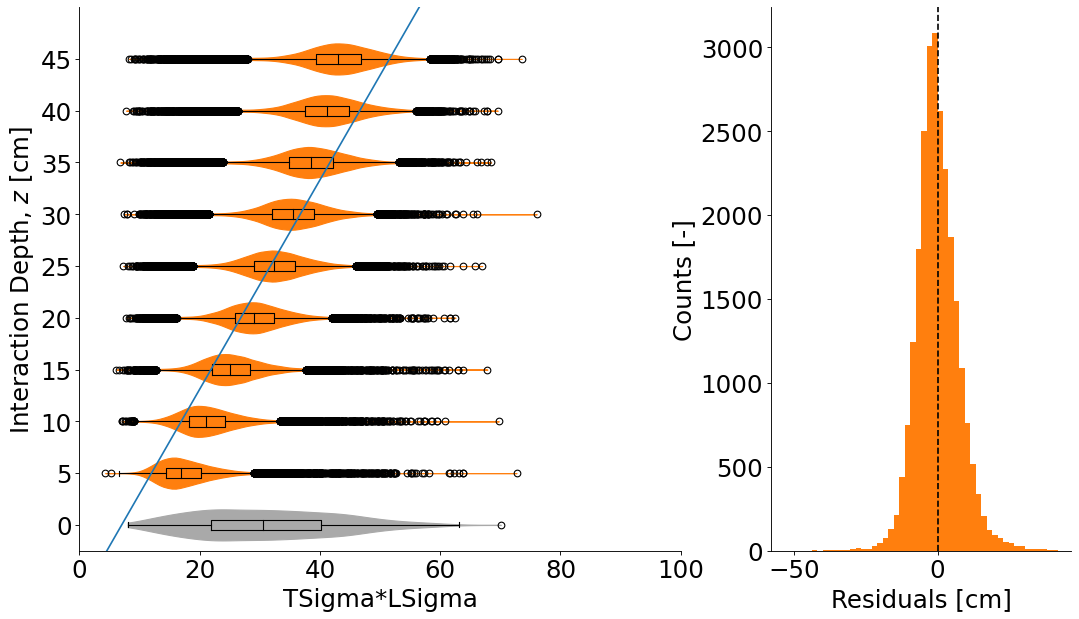

In [ ]:
feature = 'TSigma*LSigma' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}
xmin =  0#@param {type:"number"}
xmax =  100#@param {type:"number"}
roi['TSigma*LSigma'] = roi['TSigma']*roi['LSigma']


onefeat(roi, feature, xmin, xmax)

## Wrapper Methods

In [ ]:
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)

selected = np.asarray([])
scores = np.asarray([])
p = np.asarray([])
for train_index, test_index in rkf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
  sel = SelectKBest(f_regression, k=5)
  sel.fit(X_train, y_train)
  selected = np.append(selected, sel.get_feature_names_out())
  scores = np.append(scores, sel.scores_[sel.get_support(indices=True)])
  p = np.append(p, sel.pvalues_[sel.get_support(indices=True)])
data = {'Feature': selected,
        'F-Score': scores,
        'P-value': p}
df = pd.DataFrame(data)

for feature in df['Feature'].unique():
  print(feature, '\n \t f-score :', ufloat(df['F-Score'].loc[df['Feature']==feature].mean(), df['F-Score'].loc[df['Feature']==feature].std()), 
          '\n \t # selected :', df['F-Score'].loc[df['Feature']==feature].count(),
          '\n \t p-value :', ufloat(df['P-value'].loc[df['Feature']==feature].mean(), df['P-value'].loc[df['Feature']==feature].std()))
  display('-'*100)

KeyboardInterrupt: ignored

In [ ]:
##@title Forward Selection using Linear Regression
##@markdown I selected up to 5 features.
rkf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=0)

selected = np.asarray([])
scores = np.asarray([])
for train_index, test_index in rkf.split(X):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
  sfs = SequentialFeatureSelector(LinearRegression(), n_features_to_select=5)
  sfs.fit(X_train, y_train)
  selected = np.append(selected, sfs.get_feature_names_out())
  #for feature in [x for x in X_train.columns if x in X_train.columns[sfs.get_support()]]:
    #selected.append(feature)
for feature in set(selected):
  print(feature, selected.count(feature))
display('-'*100)

['TChi2' 'TSigma' 'LSigma' 'Pixel' 'eta' 'TChi2' 'TSigma' 'LSigma' 'Pixel'
 'eta' 'TChi2' 'TSigma' 'LSigma' 'Pixel' 'eta' 'TChi2' 'TSigma' 'LSigma'
 'Pixel' 'eta' 'TChi2' 'TSigma' 'LSigma' 'Pixel' 'eta' 'TChi2' 'TSigma'
 'LSigma' 'Pixel' 'eta' 'TChi2' 'TSigma' 'LSigma' 'Pixel' 'eta' 'TChi2'
 'TSigma' 'LSigma' 'Pixel' 'eta' 'TChi2' 'TSigma' 'LSigma' 'Pixel' 'eta'
 'TChi2' 'TSigma' 'LSigma' 'Pixel' 'eta']


'----------------------------------------------------------------------------------------------------'

# Z-estimate


## Wrapper methods

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

fit_data = roi.loc[roi['z[cm]']>0] 
x = fit_data.drop(['z[cm]'], axis=1)
y = fit_data['z[cm]']

RFE_regressor = LinearRegression()#SVR(kernel='linear')#

for nfeat in range(1,6):
  print('For '+str(nfeat)+' features:')
  rfe = RFE(RFE_regressor, n_features_to_select=nfeat, step=1)
  rfe = rfe.fit(x,y)
  print(x.columns[rfe.support_])
  print(rfe.score(x,y))

For 1 features:
Index(['TSigma'], dtype='object')
0.5601060664685693
For 2 features:
Index(['TSigma', 'LSigma'], dtype='object')
0.6384074740235497
For 3 features:
Index(['TSigma', 'LSigma', 'eta'], dtype='object')
0.6384241291958714
For 4 features:
Index(['TSigma', 'RMS', 'LSigma', 'eta'], dtype='object')
0.6573803859312641
For 5 features:
Index(['Slim', 'TSigma', 'RMS', 'LSigma', 'eta'], dtype='object')
0.6573847455068815


"\nRFE_regressor = LinearRegression()\nrfe = RFE(RFE_regressor, n_features_to_select=5, step=1)\n\nrfe = rfe.fit(x,y)\n\nfor index in range(0, len(rfe.ranking_)):\n  print(x.columns[index], str('\t'), rfe.ranking_[index])\n  "